In [60]:
# Utilities
from pathlib import Path
import os, sys
import subprocess as sp

# Data
import pandas as pd
import numpy as np

# Brain
import nibabel as nb
from nibabel.freesurfer.io import read_annot, read_label, read_morph_data, read_geometry
import cortex
import src.mesh_laplace_sulci

import gdist
import pygeodesic.geodesic as geodesic

# Plotting
from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt

from utility_funcs import mris_convert_command

# Meshes
import igl
import meshplot 






## Desired functions

1. Get ROI: using four boundary sulci, get all faces and vertices within them  
2. Get centroid: find the centroid of a label
3. Get crowns: find the gyral crowns (or pits) within a label
4. Autosegment: surface simplification for data-driven segmentation of labels
5. Geodesic distance: geodesic distance AND path between sets of vertices

Idea for 1:
- Get boundary vertices  
- draw geodesic path among boundary vertices  
- Geodesic path among edges i.e. superior edge of anterior -> anterior edge of superior  
- being at superior of anterior, move one edge posterior and inferior  
- if target vertex is not in boundary vertices, add face to label  
- if target vertex is in boundary vertices, select other edge ~~ which edge? spiral through  
  - before adding check all three adjacent triangles  
  - plan to go to next triangle which has border with added vertex  

In [4]:
# filepath = '/Users/benparker/Desktop/cnl/subjects/100307/surf/lh.pial'

# mris_convert_command(filepath, custom_filename='mris_convert')

In [8]:
subjects_dir = '/Users/benparker/Desktop/cnl/subjects'
labels = ['POS','MCGS']
sub = '100307'
hemi = 'lh'
outdir = '/Users/benparker/Desktop/cnl/CNL_scalpel/results'

#getDistMatrix(subjects_dir,labels,sub,hemi,outdir, fmri_prep=False)

In [9]:
highres_surface = f'{subjects_dir}/{sub}/surf/{hemi}.pial'
    
 
giidata = nb.freesurfer.read_geometry(highres_surface)
points, faces = giidata[0], giidata[1]

label_ind = nb.freesurfer.read_label('/Users/benparker/Desktop/cnl/subjects/100307/label/rh.MCGS.label')
label_points = points[label_ind]
label_faces = faces[label_ind]


In [10]:
unique_entry, count = np.unique(label_faces, return_counts=True)


In [11]:
len(faces)

261754

In [21]:
adjacency = mesh_to_adjacency(faces, points)
adacent_nodes = adjacenct_nodes(adjacency, 0)

    

    

In [56]:
ant_nodes = boundary_dict['anterior'][0]
ant_nodes

ant_points = boundary_dict['anterior'][1]
ant_points

array([[ -3.715, -22.797,  10.039],
       [ -4.014, -23.772,  10.159],
       [ -4.318, -21.824,  10.332],
       [ -4.735, -22.932,  10.412],
       [ -3.458, -21.042,  10.529],
       [ -4.858, -23.936,  10.611],
       [ -5.016, -21.2  ,  10.691],
       [ -5.393, -22.016,  10.752],
       [ -5.956, -21.029,  11.01 ],
       [ -5.591, -22.952,  11.329],
       [ -5.151, -24.146,  11.363],
       [ -6.737, -21.264,  11.524],
       [ -6.405, -22.431,  11.656],
       [ -7.025, -21.885,  12.076],
       [ -5.005, -24.354,  12.234],
       [ -7.605, -21.414,  12.402],
       [ -8.028, -21.199,  12.509],
       [ -6.903, -22.315,  12.94 ],
       [ -6.282, -22.939,  13.009],
       [ -5.463, -23.583,  13.193],
       [ -9.098, -21.756,  13.323],
       [ -6.785, -22.673,  13.45 ],
       [-11.145, -21.001,  13.541],
       [-10.135, -21.621,  13.58 ],
       [ -7.435, -22.501,  13.668],
       [-11.696, -21.114,  13.832],
       [ -9.723, -22.383,  13.929],
       [ -6.64 , -23.174,  1

In [55]:
np.take(points, ant_nodes, axis=0)

array([[  0.52837843, -25.54247665,  10.90169716],
       [  0.48978198, -26.56030846,  10.11506176],
       [ -0.42324719, -24.27235413,  12.21739006],
       [ -0.40475774, -25.09004021,  11.41326904],
       [  0.14730568, -23.81792831,  12.68358135],
       [ -0.07052274, -26.07647324,  10.70414734],
       [ -1.57668173, -23.24120331,  12.97258091],
       [ -1.62239957, -23.65618134,  12.53680229],
       [ -2.89825106, -22.40502548,  13.34264755],
       [ -1.59732521, -24.07579613,  12.05012417],
       [ -0.35537589, -25.66177368,  10.98719025],
       [ -3.90793014, -21.68163109,  13.46074963],
       [ -2.95126748, -22.76278687,  12.83941269],
       [ -4.11269522, -21.55568695,  13.53550243],
       [ -0.41909611, -25.43466949,  11.18797588],
       [ -5.27078485, -20.76982307,  14.01995754],
       [ -5.98778248, -20.48815727,  14.09105587],
       [ -4.26033354, -21.6124115 ,  13.72908306],
       [ -3.14989305, -22.48085213,  13.21479034],
       [ -1.84315026, -23.57583

In [17]:
label_annot = nb.freesurfer.read_annot('/Users/benparker/Desktop/cnl/subjects/100307/label/lh.PFC_annot.annot')

for id in np.unique(label_annot[0]):
    print('id = %d, sum = %d'%(id, (label_annot[0] == id).sum()))

id = -1, sum = 118706
id = 0, sum = 3643
id = 1, sum = 1131
id = 2, sum = 831
id = 3, sum = 832
id = 4, sum = 1639
id = 5, sum = 772
id = 6, sum = 397
id = 7, sum = 535
id = 8, sum = 1444
id = 9, sum = 698
id = 10, sum = 251


In [16]:


geoalg = geodesic.PyGeodesicAlgorithmExact(points, faces)
sourceIndex = 25
targetIndex = 97
# Compute the geodesic distance and the path
distance, path = geoalg.geodesicDistance(sourceIndex, targetIndex)
path

array([[ -1.35481012, -76.9079895 , -11.9917984 ],
       [ -1.8057055 , -77.16084878, -12.15658785],
       [ -2.42826358, -77.44982389, -12.38781169],
       [ -2.59597011, -77.52264554, -12.45038318],
       [ -2.73134925, -77.57722628, -12.50106535],
       [ -3.34306614, -77.79669552, -12.7320138 ],
       [ -3.7647475 , -77.88611146, -12.89647065],
       [ -4.05438525, -77.93750909, -13.01024463],
       [ -4.35890905, -77.98404561, -13.13057137],
       [ -4.76563425, -78.02666812, -13.29281327],
       [ -5.27875079, -78.0546205 , -13.49930141],
       [ -5.5109015 , -78.05079138, -13.59323869],
       [ -5.65983488, -78.07304257, -13.65324915],
       [ -6.43935061, -78.11183167, -13.97138786]])

## Find boundary

In [26]:
## Load labels for boundary sulci


vertices, coords = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')
label_MCGS = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')

r_data = np.array([ras[0] for ras in coords])
a_data = np.array([ras[1] for ras in coords])
s_data = np.array([ras[2] for ras in coords])




In [32]:
test_vert_num, test_verts = find_boundary_vertices(boundary='anterior', read_label=label_MCGS, outlier_corrected=True, decimal_size=1)

test_r_data_min_inferior = np.array([ras[0] for ras in test_verts])
test_a_data_min_inferior = np.array([ras[1] for ras in test_verts])
test_s_data_min_inferior = np.array([ras[2] for ras in test_verts])



Text(0.5, 0.98, 'all vertices of MCGS vs anterior boundary')

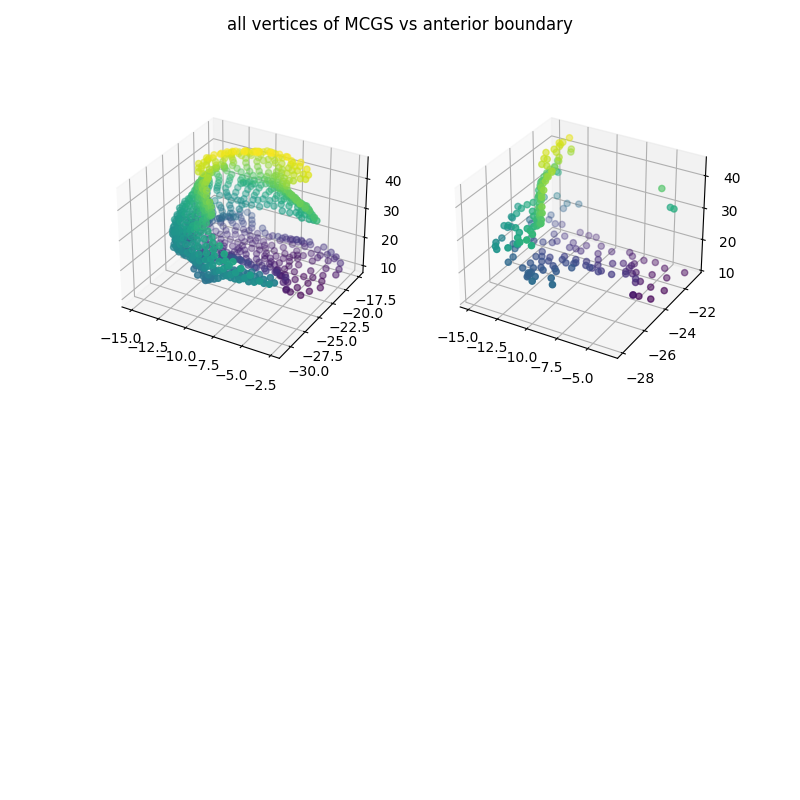

In [33]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax1.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# Getting lower bound of the sulcus

ax2.scatter3D(test_r_data_min_inferior, test_a_data_min_inferior, test_s_data_min_inferior, cmap='viridis', c=test_s_data_min_inferior, vmin=10, vmax=45)
ax2.set(zlim3d=[10,45]);
plt.suptitle('all vertices of MCGS vs anterior boundary')

## Surfaces and cutting

In [45]:
test_sub = ScalpelSurface(subject_filepath='~/Desktop/cnl/subjects/100307')

In [50]:
boundary_dict = test_sub.get_boundary(anterior_label='MCGS', posterior_label='POS', inferior_label='2', superior_label='MCGS', hemi='lh')
        

In [51]:
boundary_dict

{'anterior': [array([42957, 41937, 44038, 42958, 45085, 41938, 44018, 42932, 44019,
         41911, 40923, 44001, 41912, 42916, 40908, 42917, 43987, 42900,
         41865, 41864, 42902, 42879, 43991, 42903, 42880, 43974, 42882,
         41839, 42883, 41838, 43975, 41840, 41841, 41843, 42863, 42864,
         41808, 42865, 41810, 41813, 40853, 40852, 42852, 41783, 41784,
         43955, 42853, 41788, 40824, 40827, 40825, 40826, 43945, 40801,
         41766, 40802, 40800, 40798, 40799, 40770, 40771, 39791, 39771,
         40769, 41750, 39772, 43936, 39773, 39750, 39749, 41737, 39751,
         43925, 39748, 38838, 38837, 38836, 42824, 38815, 38814, 38789,
         37846, 37845, 38788, 39730, 43912, 38791, 37824, 39708, 37823,
         41711, 38765, 37799, 44979, 37800, 39692, 43893, 40671, 43869,
         38709, 38710, 42733, 38702, 37722, 39651, 36793, 37710, 39645,
         38685, 40615, 38677, 36771, 39635, 38671, 38670, 40610, 37686,
         38669, 43787, 40602, 38666, 43780, 37681, 4

In [67]:
test_r_data_min_inferior = np.array([ras[0] for ras in label_points[edge]])
test_a_data_min_inferior = np.array([ras[1] for ras in label_points[edge]])
test_s_data_min_inferior = np.array([ras[2] for ras in label_points[edge]])



IndexError: index 18428 is out of bounds for axis 0 with size 625

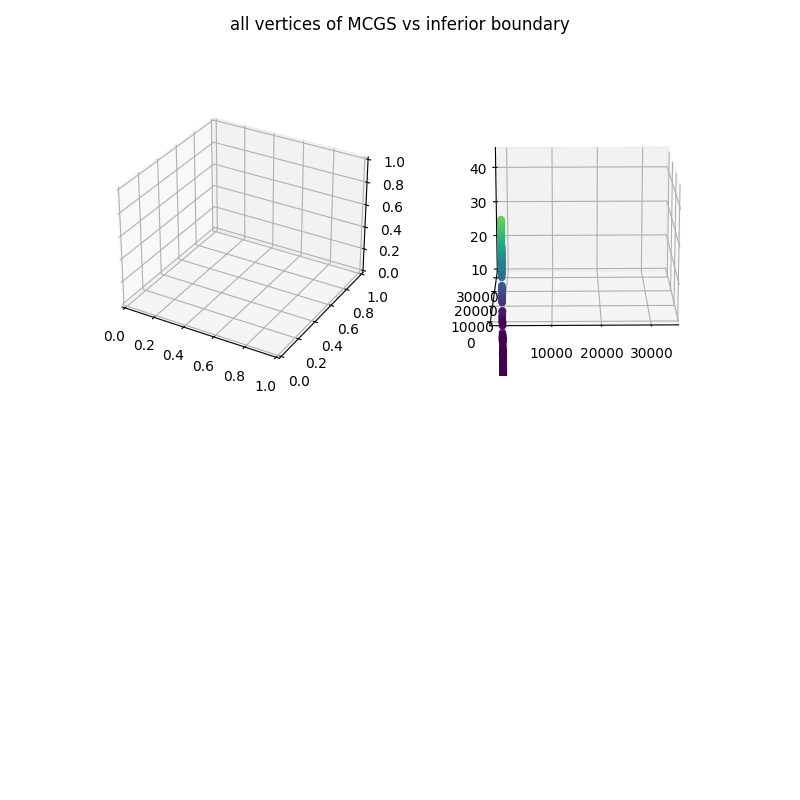

In [61]:

# Getting lower bound of the sulcus

ax2.scatter3D(test_r_data_min_inferior, test_a_data_min_inferior, test_s_data_min_inferior, cmap='viridis', c=test_s_data_min_inferior, vmin=10, vmax=45)

plt.suptitle('all vertices of MCGS vs inferior boundary')
plt.show();

## Pycortex

In [ ]:

# project_dir = Path('/Users/benparker/Desktop/cnl/CNL_scalpel/results/')
# subjects_dir = Path('/Users/benparker/Desktop/cnl/subjects/')
# subjects_dir_str = '/Users/benparker/Desktop/cnl/subjects/'

# ## read_annot returns [0] labels at each vertex, -1 for no id [1]: ctab [2]: label names 
# annot_verts, annot_ctab, annot_names = read_annot(subjects_dir / '100307/label/rh.aparc.a2009s.annot')


# # import test subject to pycortex db
# cortex.freesurfer.import_subj('100307', freesurfer_subject_dir=subjects_dir_str, whitematter_surf='white')


In [ ]:


## split FC map by boundary sulci

##### ID vertices within boundary by [0] from read annot

## Mesh traversal

In [212]:
subjects_dir = '/Users/benparker/Desktop/cnl/subjects'
labels = ['POS','MCGS']
sub = '100307'
hemi = 'lh'
outdir = '/Users/benparker/Desktop/cnl/CNL_scalpel/results'

#getDistMatrix(subjects_dir,labels,sub,hemi,outdir, fmri_prep=False)

highres_surface = f'{subjects_dir}/{sub}/surf/{hemi}.pial'
    
 
giidata = nb.freesurfer.read_geometry(highres_surface)
points, faces = giidata[0], giidata[1]

label_ind, label_points = nb.freesurfer.read_label('/Users/benparker/Desktop/cnl/subjects/100307/label/rh.POS.label', read_scalars=True)

label_faces = faces[label_ind]

label_ind_POS, label_RAS = read_label('/Users/benparker/Desktop/cnl/subjects/100307/label/rh.POS.label')
label_points_POS = points[label_ind_POS]
label_faces_POS = faces[label_ind_POS]


In [96]:
label_ind

array([13243, 13244, 13251, ..., 35287, 35288, 35289])

In [175]:


def get_label_faces(points, faces, label_ind):
    """ Takes a list of points in XYZ space and a list of faces composed of 3 points. 
    Identify which faces include the points at points[label_index]
    Return the faces that contain the points.

    INPUT:
    points: array of points in XYZ space
    faces: array of faces composed of 3 points
    label_ind: array of indices of points in the label

    OUTPUT:
    label_faces: array of faces that contain the points in the label
    """
    all_label_faces = []
    label_points = points[label_ind]

    for face in faces[:5]:
        for point_index in face:
            point_in_face = points[point_index]
            if check_if_in_list(face, label_ind):
                all_label_faces.append(list(face))

    return np.array(all_label_faces)

In [184]:
def get_faces_for_label(faces, label_ind):
    """
    Takes a list of faces and label indices
    Returns the faces that contain the indices

    INPUT:
    faces: array of faces composed of 3 points
    label_ind: array of indices of points in the label

    OUTPUT:
    label_faces: array of faces that contain the points in the label
    """
    all_label_faces = []
    for face in faces:
        for point_index in face:
            if point_index in label_ind:
                all_label_faces.append(list(face))
    return np.array(all_label_faces)

In [191]:
label_faces = get_faces_for_label(faces, label_ind)

In [ ]:
## TODO these two plots look like they're different, they shouldn't

In [206]:
meshplot.plot(label_RAS)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(17.123499…

In [211]:
meshplot.plot(points, faces)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…